In [1]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#path = kagglehub.dataset_download("prajwaldongre/loan-application-and-transaction-fraud-detection")

In [3]:
df1 = pd.read_csv("/home/mousefish/.cache/kagglehub/datasets/prajwaldongre/loan-application-and-transaction-fraud-detection/versions/1/loan_applications.csv")  # уточните название файла

In [4]:
df2 = pd.read_csv("/home/mousefish/.cache/kagglehub/datasets/prajwaldongre/loan-application-and-transaction-fraud-detection/versions/1/transactions.csv")  # уточните название файла

In [5]:
# Выбор категориальных столбцов
cat_columns1 = [
    'loan_type',
    'purpose_of_loan',
    'employment_status',
    'property_ownership_status',
    'gender',
    'loan_status'
]
cat_columns1 = df1[cat_columns1]
# Выбор числовых столбцов 
# Список числовых столбцов для обработки
numeric_cols = [
    'loan_amount_requested', 
    'loan_tenure_months',
    'interest_rate_offered',
    'monthly_income',
    'cibil_score',
    'existing_emis_monthly',
    'debt_to_income_ratio',
    'applicant_age',
    'number_of_dependents'
]
mean_values1 = df1[numeric_cols].mean()

In [6]:
# Выбор числовых столбцов
numeric_columns2 = df2.select_dtypes(include=['float64']).columns
mean_values2 = df2[numeric_columns2].mean()

In [7]:
def calculate_emi(row):
    principal = row['loan_amount_requested']
    rate = row['interest_rate_offered'] / 1200  # Месячная ставка
    tenure = row['loan_tenure_months']
    
    if rate == 0:
        return principal / tenure
    else:
        factor = (1 + rate) ** tenure
        return principal * rate * factor / (factor - 1)

df1['monthly_loan_payment'] = df1.apply(calculate_emi, axis=1)

In [8]:
df1['total_monthly_obligations'] = df1['existing_emis_monthly'] + df1['monthly_loan_payment']
df1['obligation_to_income_ratio'] = df1['total_monthly_obligations'] / df1['monthly_income']
df1['application_date'] = pd.to_datetime(df1['application_date'])
df1['application_month'] = df1['application_date'].dt.month
df1['application_weekday'] = df1['application_date'].dt.dayofweek  # 0=понедельник, 6=воскресенье
bins = [20, 30, 40, 50, 60, 70]
labels = ['20-29', '30-39', '40-49', '50-59', '60+']
df1['age_group'] = pd.cut(df1['applicant_age'], bins=bins, labels=labels, right=False)

In [9]:
print(df1[['monthly_loan_payment', 'total_monthly_obligations', 
           'obligation_to_income_ratio', 'application_month', 
           'application_weekday', 'age_group']].head())


   monthly_loan_payment  total_monthly_obligations  \
0          53568.646498               54668.646498   
1           1216.018714                1216.018714   
2           9457.190714               14057.190714   
3           4346.534187                8346.534187   
4           3424.566586                4524.566586   

   obligation_to_income_ratio  application_month  application_weekday  \
0                    1.575465                  4                    6   
1                    0.023566                  9                    5   
2                    0.949810                  5                    0   
3                    0.289810                  7                    1   
4                    0.103065                 11                    0   

  age_group  
0     20-29  
1     40-49  
2     50-59  
3     20-29  
4     50-59  


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   application_id              50000 non-null  object        
 1   customer_id                 50000 non-null  object        
 2   application_date            50000 non-null  datetime64[ns]
 3   loan_type                   50000 non-null  object        
 4   loan_amount_requested       50000 non-null  float64       
 5   loan_tenure_months          50000 non-null  int64         
 6   interest_rate_offered       50000 non-null  float64       
 7   purpose_of_loan             50000 non-null  object        
 8   employment_status           50000 non-null  object        
 9   monthly_income              50000 non-null  float64       
 10  cibil_score                 50000 non-null  int64         
 11  existing_emis_monthly       50000 non-null  float64   

In [11]:
df1['fraud_type'] = df1['fraud_type'].fillna('No Fraud')
# Удаление полных дубликатов
df1 = df1.drop_duplicates()

# Удаление дубликатов по application_id (сохраняем первое вхождение)
df1 = df1.drop_duplicates(subset=['application_id'], keep='first')
for col in numeric_cols:
    # Расчёт квартилей и IQR
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Определение границ
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Замена выбросов на граничные значения
    df1[col] = np.where(df1[col] < lower_bound, lower_bound, df1[col])
    df1[col] = np.where(df1[col] > upper_bound, upper_bound, df1[col])
# Корректировка возраста
df1['applicant_age'] = df1['applicant_age'].clip(21, 65)

# Корректировка числа иждивенцев
df1['number_of_dependents'] = df1['number_of_dependents'].clip(0, 4)

# Недопущение отрицательной долговой нагрузки
df1['debt_to_income_ratio'] = df1['debt_to_income_ratio'].clip(lower=0)

In [12]:
# Проверка пропусков
print("Пропуски после обработки:")
print(df1.isnull().sum())

# Проверка статистик
print("\nОписательные статистики после обработки:")
print(df1.describe())

# Проверка уникальных значений
print("\nУникальные значения в категориальных столбцах:")
print(df1[['fraud_type', 'employment_status', 'property_ownership_status']].nunique())

Пропуски после обработки:
application_id                0
customer_id                   0
application_date              0
loan_type                     0
loan_amount_requested         0
loan_tenure_months            0
interest_rate_offered         0
purpose_of_loan               0
employment_status             0
monthly_income                0
cibil_score                   0
existing_emis_monthly         0
debt_to_income_ratio          0
property_ownership_status     0
residential_address           0
applicant_age                 0
gender                        0
number_of_dependents          0
loan_status                   0
fraud_flag                    0
fraud_type                    0
monthly_loan_payment          0
total_monthly_obligations     0
obligation_to_income_ratio    0
application_month             0
application_weekday           0
age_group                     0
dtype: int64

Описательные статистики после обработки:
                 application_date  loan_amount_requeste

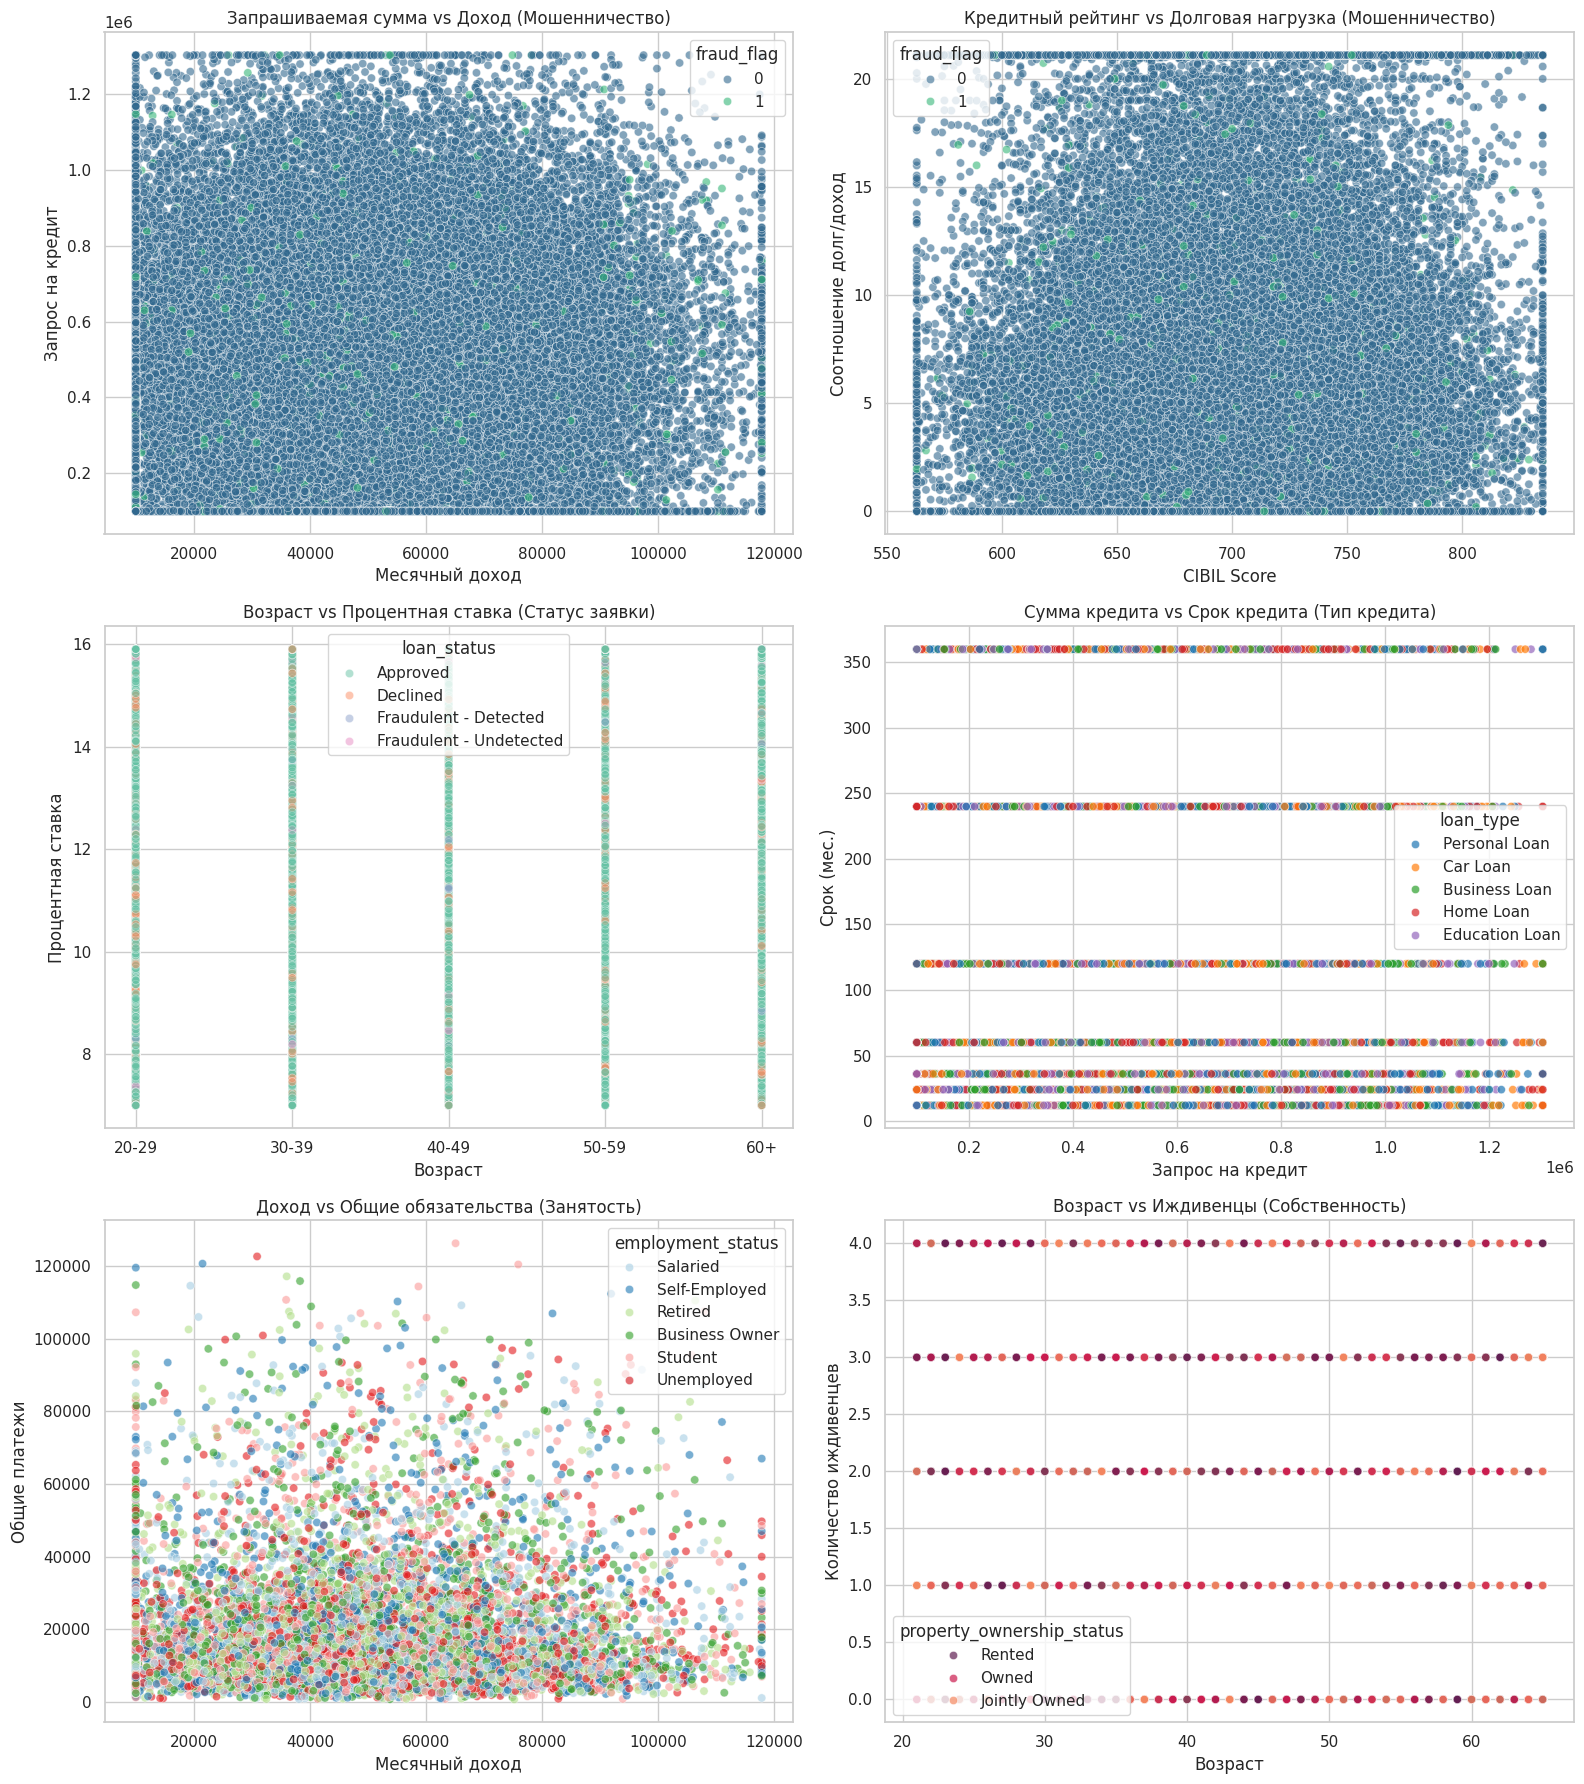

In [13]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Доход vs Запрашиваемая сумма (с маркировкой по fraud_flag)
sns.scatterplot(ax=axes[0,0], x='monthly_income', y='loan_amount_requested', 
                hue='fraud_flag', data=df1, alpha=0.6, palette='viridis')
axes[0,0].set_title('Запрашиваемая сумма vs Доход (Мошенничество)')
axes[0,0].set_xlabel('Месячный доход')
axes[0,0].set_ylabel('Запрос на кредит')

# 2. Кредитный рейтинг vs Долговая нагрузка (с маркировкой по fraud_flag)
sns.scatterplot(ax=axes[0,1], x='cibil_score', y='debt_to_income_ratio', 
                hue='fraud_flag', data=df1, alpha=0.6, palette='viridis')
axes[0,1].set_title('Кредитный рейтинг vs Долговая нагрузка (Мошенничество)')
axes[0,1].set_xlabel('CIBIL Score')
axes[0,1].set_ylabel('Соотношение долг/доход')

# 3. Возраст vs Ставка по кредиту (с маркировкой по loan_status)
sns.scatterplot(ax=axes[1,0], x='age_group', y='interest_rate_offered', 
                hue='loan_status', data=df1, alpha=0.5, palette='Set2')
axes[1,0].set_title('Возраст vs Процентная ставка (Статус заявки)')
axes[1,0].set_xlabel('Возраст')
axes[1,0].set_ylabel('Процентная ставка')

# 4. Сумма кредита vs Срок (с маркировкой по loan_type)
sns.scatterplot(ax=axes[1,1], x='loan_amount_requested', y='loan_tenure_months', 
                hue='loan_type', data=df1.sample(10000), alpha=0.7, palette='tab10')
axes[1,1].set_title('Сумма кредита vs Срок кредита (Тип кредита)')
axes[1,1].set_xlabel('Запрос на кредит')
axes[1,1].set_ylabel('Срок (мес.)')

# 5. Доход vs Обязательства (с маркировкой по employment_status)
sns.scatterplot(ax=axes[2,0], x='monthly_income', y='total_monthly_obligations', 
                hue='employment_status', data=df1.sample(10000), alpha=0.6, palette='Paired')
axes[2,0].set_title('Доход vs Общие обязательства (Занятость)')
axes[2,0].set_xlabel('Месячный доход')
axes[2,0].set_ylabel('Общие платежи')

# 6. Возраст vs Количество иждивенцев (с маркировкой по property_ownership)
sns.scatterplot(ax=axes[2,1], x='applicant_age', y='number_of_dependents', 
                hue='property_ownership_status', data=df1, alpha=0.7, palette='rocket')
axes[2,1].set_title('Возраст vs Иждивенцы (Собственность)')
axes[2,1].set_xlabel('Возраст')
axes[2,1].set_ylabel('Количество иждивенцев')

plt.tight_layout()
plt.show()

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
features = [
    'loan_amount_requested',
    'monthly_income',
    'cibil_score',
    'debt_to_income_ratio',
    'total_monthly_obligations',
    'applicant_age'
]

X = df1[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

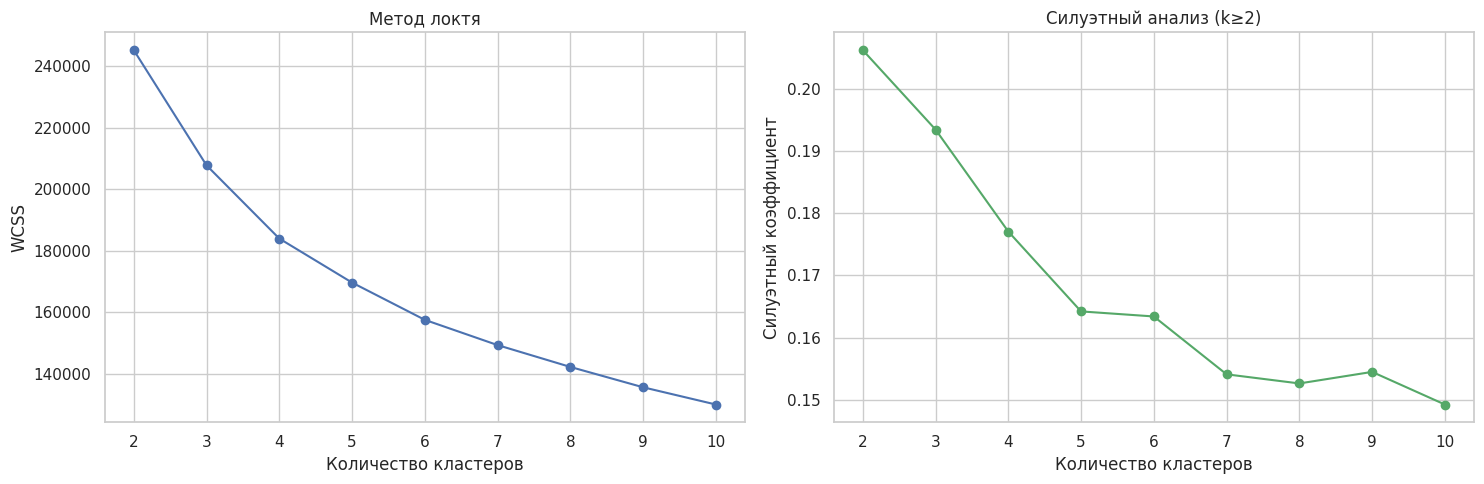

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Определение оптимального числа кластеров
wcss = []
silhouette_scores = []
k_range = list(range(2, 11))  # [2,3,…,10]

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    wcss.append(km.inertia_)
    
    # силуэт для всех k>=2
    silhouette_scores.append(silhouette_score(X_scaled, km.labels_))

# Визуализация
plt.figure(figsize=(15, 5))

# 1) Метод локтя
plt.subplot(1, 2, 1)              # слот 1
plt.plot(k_range, wcss, 'bo-')
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.xticks(k_range)

# 2) Силуэтный анализ
plt.subplot(1, 2, 2)              # слот 2
plt.plot(k_range, silhouette_scores, 'go-')
plt.title('Силуэтный анализ (k≥2)')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэтный коэффициент')
plt.xticks(k_range)

plt.tight_layout()
plt.show()

Локоть примерно на k=4, силуэтный коэффициент в этой точке равен примерно 0.178. Кластеры плохо разделены, имеет место быть значительное перекрытие. Это нормально для финансовых данных

In [23]:
# Обучаем модель с 4 кластерами
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(X_scaled)
df1['cluster'] = kmeans.labels_
# Группируем данные по кластерам
cluster_analysis = df1.groupby('cluster').agg({
    'loan_amount_requested': 'mean',
    'monthly_income': 'mean',
    'cibil_score': 'mean',
    'debt_to_income_ratio': 'mean',
    'total_monthly_obligations': 'mean',
    'applicant_age': 'mean',
    'fraud_flag': ['mean', 'sum', 'count']
})

# Переименовываем столбцы для ясности
cluster_analysis.columns = [
    'avg_loan_amount',
    'avg_monthly_income',
    'avg_cibil_score',
    'avg_debt_ratio',
    'avg_monthly_obligations',
    'avg_age',
    'fraud_rate',
    'fraud_count',
    'total_count'
]

# Добавляем долю кластера
cluster_analysis['cluster_share'] = cluster_analysis['total_count'] / len(df1)

# Сортируем по fraud_rate
cluster_analysis = cluster_analysis.sort_values('fraud_rate', ascending=False)

# Выводим результаты
print(cluster_analysis)

         avg_loan_amount  avg_monthly_income  avg_cibil_score  avg_debt_ratio  \
cluster                                                                         
0          492434.496712        22470.217501       699.350126       17.064821   
2          454111.603689        59182.157096       699.387861        4.799554   
3          831612.024957        53857.026375       700.944980        6.577827   
1          450129.197933        58078.914996       698.005290        4.822994   

         avg_monthly_obligations    avg_age  fraud_rate  fraud_count  \
cluster                                                                
0                   17234.203844  42.649772    0.021244          210   
2                   13113.199604  54.676584    0.020708          348   
3                   52332.711807  42.865995    0.020136          142   
1                   12793.484829  31.388855    0.020052          326   

         total_count  cluster_share  
cluster                              
0   

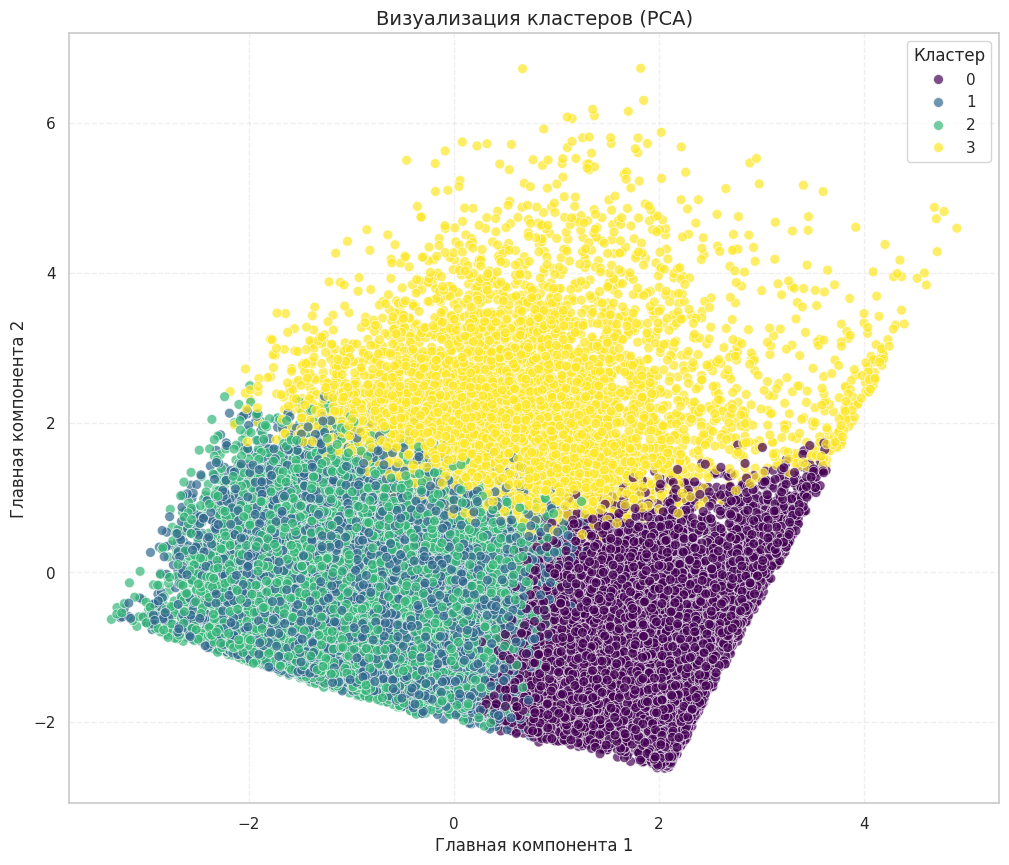

In [24]:
from sklearn.decomposition import PCA
import seaborn as sns

# Снижение размерности для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=X_pca[:,0], 
    y=X_pca[:,1], 
    hue=df1['cluster'],
    palette='viridis',
    alpha=0.7,
    s=50
)
plt.title('Визуализация кластеров (PCA)', fontsize=14)
plt.xlabel('Главная компонента 1', fontsize=12)
plt.ylabel('Главная компонента 2', fontsize=12)
plt.legend(title='Кластер')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

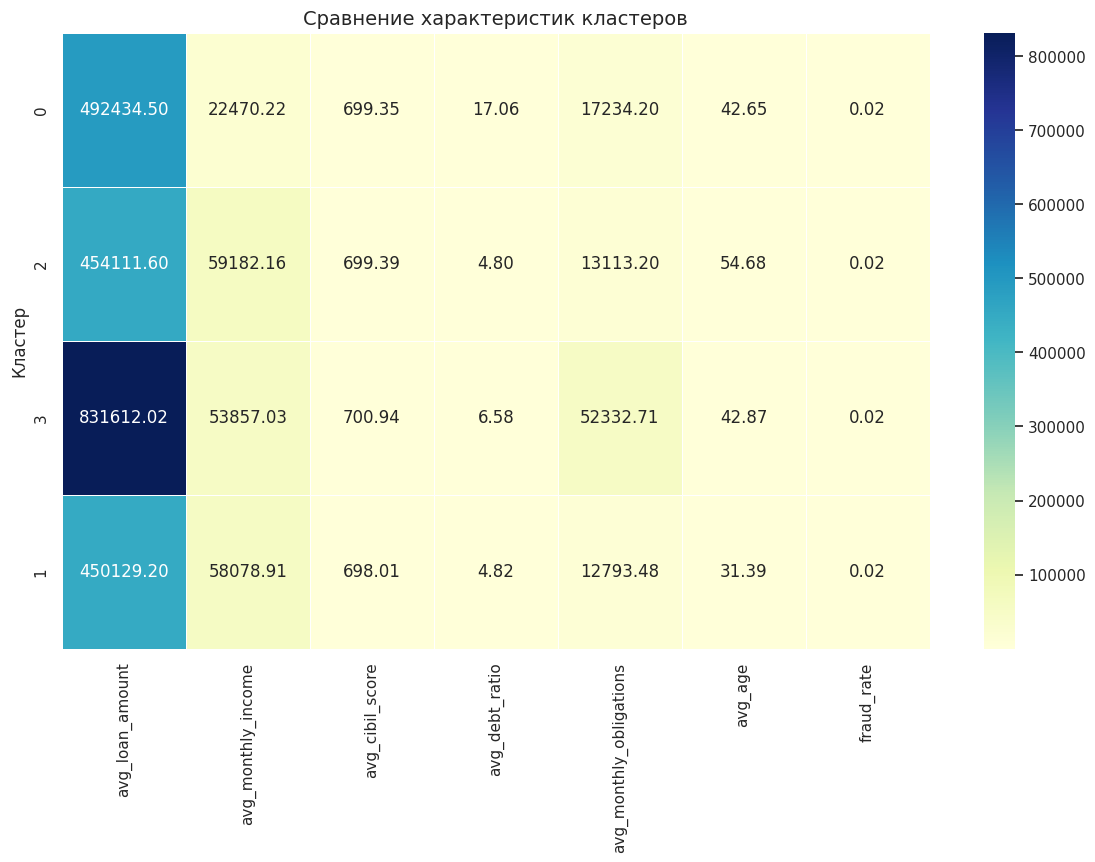

In [25]:
# Тепловая карта характеристик кластеров
plt.figure(figsize=(14, 8))
sns.heatmap(
    cluster_analysis[
        ['avg_loan_amount', 'avg_monthly_income', 'avg_cibil_score',
         'avg_debt_ratio', 'avg_monthly_obligations', 'avg_age', 'fraud_rate']
    ],
    annot=True,
    cmap='YlGnBu',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Сравнение характеристик кластеров', fontsize=14)
plt.ylabel('Кластер', fontsize=12)
plt.show()

К сожалению все кластеры обладают одинаковым fraud_rate - показателем мошенничества.